In [1]:
pip install torch torchvision matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

In [3]:
# Verify if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set paths to dataset
data_dir = "./dataset/dataset-reduced"  
output_dir = "./output/reduced-dataset/mobilenet-cnn"

In [5]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True,num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=8)

In [7]:
# Use pre-trained MobileNet model
class MobileNetClassifier(nn.Module):
    def __init__(self):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        for param in self.mobilenet.features.parameters():
            param.requires_grad = False
        # Replace the classifier with a custom classifier
        self.mobilenet.classifier[1] = nn.Sequential(
            nn.Linear(self.mobilenet.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mobilenet(x)

model = MobileNetClassifier().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.mobilenet.classifier.parameters(), lr=0.001)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save training and validation metrics plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"{output_dir}/training_validation_loss.png")

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/validation_accuracy.png")

    return train_losses, val_losses, val_accuracies

Epoch 1, Train Loss: 0.1090, Validation Loss: 0.0507, Validation Accuracy: 0.9816
Epoch 2, Train Loss: 0.0749, Validation Loss: 0.0616, Validation Accuracy: 0.9772
Epoch 3, Train Loss: 0.0659, Validation Loss: 0.0356, Validation Accuracy: 0.9871
Epoch 4, Train Loss: 0.0576, Validation Loss: 0.0310, Validation Accuracy: 0.9889
Epoch 5, Train Loss: 0.0534, Validation Loss: 0.0465, Validation Accuracy: 0.9828
Epoch 6, Train Loss: 0.0483, Validation Loss: 0.0278, Validation Accuracy: 0.9898
Epoch 7, Train Loss: 0.0462, Validation Loss: 0.0258, Validation Accuracy: 0.9907
Epoch 8, Train Loss: 0.0429, Validation Loss: 0.0239, Validation Accuracy: 0.9912
Epoch 9, Train Loss: 0.0409, Validation Loss: 0.0223, Validation Accuracy: 0.9915
Epoch 10, Train Loss: 0.0400, Validation Loss: 0.0227, Validation Accuracy: 0.9914
Epoch 11, Train Loss: 0.0349, Validation Loss: 0.0208, Validation Accuracy: 0.9923
Epoch 12, Train Loss: 0.0372, Validation Loss: 0.0234, Validation Accuracy: 0.9917
Epoch 13, Tra

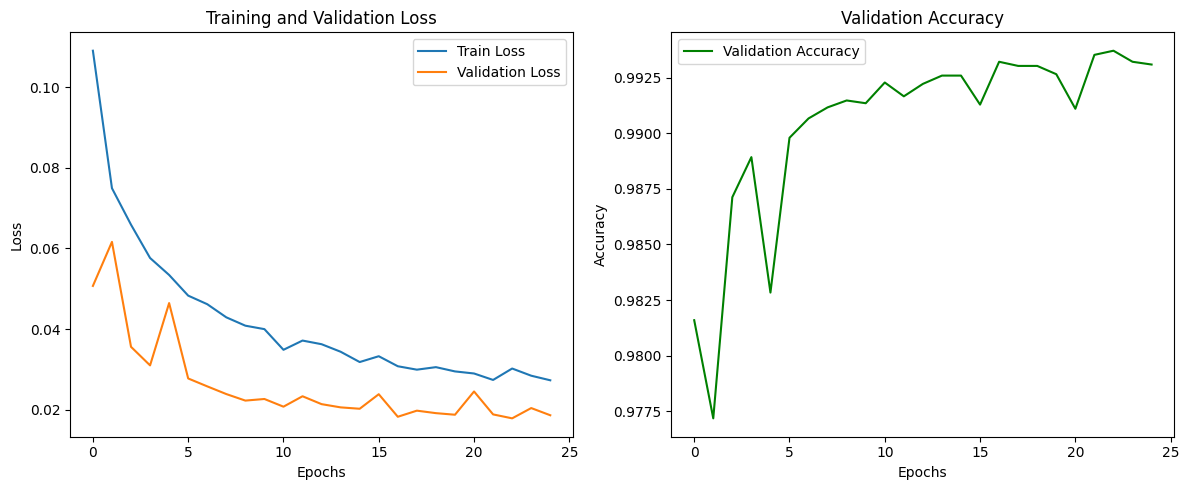

In [10]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=25)

1. Excellent Generalization: The model consistently performs well across epochs with a validation accuracy that peaks at 99.37% in Epoch 23. This indicates that the model generalizes well to unseen data.
2. Stable Training Process: Both the training loss and validation loss are steadily decreasing, and the accuracy is increasing. This shows the model is learning effectively without overfitting, as evidenced by the stable losses and high validation accuracy.
3. Improvement Over Time: The model starts with a validation accuracy of 98.16% in the first epoch and improves to 99.31% in the last epoch, reflecting solid learning progress and optimization.

In [11]:
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save test results to a file
    with open(f"{output_dir}/test_results.txt", "w") as f:
        f.write(f"Test Loss: {avg_test_loss:.4f}\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")

    return avg_test_loss, test_accuracy


In [12]:
# Call the test_model function
test_loss, test_accuracy = test_model(model, test_loader, device)

Test Loss: 0.0169, Test Accuracy: 0.9944


High Test Accuracy: The test accuracy of 99.44% is very impressive, confirming that the MobileNet model generalizes extremely well to the unseen test data.
Low Test Loss: The low test loss indicates that the model's predictions are highly accurate with minimal error on the test set, further supporting its robustness.

In [13]:
# Save the model
torch.save(model.state_dict(), f"{output_dir}/reduced_mobilenet_cnn_weights.pth")
print("Model training and testing complete. Plots and results saved.")

Model training and testing complete. Plots and results saved.
